In [1]:
import tensorflow as tf

In [2]:
import numpy as np

In [3]:
import pandas as pd

In [4]:
import mne

In [5]:
import os

In [6]:
import keras

Using TensorFlow backend.


In [7]:
import seaborn as sns

In [8]:
from collections import Counter

In [9]:
from tqdm import tqdm_notebook
from tqdm import tqdm_notebook as tqdm

In [10]:
import matplotlib.pyplot as plt

Какие каналы содержат 

Dataset:
- Один сэмпл содержит чанк сигнала, чанки не пересекаются
- Считывание происходит из случайных файлов из списка
- Чанки рандомизированы:
    - Учесть рандомизацию по номеру пациента, сессии, времени

# Read labels

In [11]:
header = ["file", "start", "end", "label", "confidence"]
train_df = pd.read_csv("../_DOCS/ref_train.txt", sep=" ", names=header)
val_df = pd.read_csv("../_DOCS/ref_dev.txt", sep=" ", names=header)

In [12]:
def preprocess_file(full_file):
    parts = full_file.split("_")
    patient = int(parts[0])
    session = int(parts[1][1:])
    file = int(parts[2][1:])
    return [patient, session, file]

In [13]:
preprocess_file("00000258_s002_t000")

[258, 2, 0]

In [14]:
def append_file_info(df):
    values = np.array(df["file"].apply(preprocess_file).tolist())
    files_df = pd.DataFrame(values, columns=["patient", "session", "chunk"], index=df.index)
    return df.merge(files_df, how="inner", left_index=True, right_index=True)

In [15]:
train_df = append_file_info(train_df)

In [16]:
val_df = append_file_info(val_df)

# Attach files

TODO add other electrode formats

In [17]:
def attach_files(df, dataset):
    paths = {}

    for root, dirs, files in os.walk("../edf/{}".format(dataset)):
        path = root.split(os.sep)
        for file in files:
            if ".edf" in file:
                name = file.split(".")[0]
                paths[name] = os.path.abspath(root) + "/" +  file
    
    df["full_path"] = df["file"].apply(paths.get)
    df = df[df["full_path"].apply(lambda x: "01_tcp_ar" in str(x))].copy()
    return df

In [18]:
train_df = attach_files(train_df, "train")

In [19]:
val_df = attach_files(val_df, "dev")

# Separate patients

In [20]:
train_patients = train_df["patient"].unique() 

In [21]:
val_patients = val_df["patient"].unique()

In [22]:
val_df = val_df[~val_df["patient"].isin(train_patients)].copy()

# Remove bckg files

In [23]:
def remove_bckg_files(df):
    files_with_seizures = df[df["label"] == "seiz"]["file"].unique()
    return df[df["file"].isin(files_with_seizures)].copy()

In [24]:
train_df = remove_bckg_files(train_df)

In [25]:
val_df = remove_bckg_files(val_df)

# Calculate channels intersection and proper sample rate

In [26]:
def get_edf_info(df):
    files = df["full_path"].unique()

    edf_data = []

    for file in tqdm_notebook(files):
        edf = mne.io.read_raw_edf(file, verbose="ERROR")
        data = {
            field: edf.info[field]
            for field in ["ch_names", "sfreq"]
        }
        edf_data.append(data)
        
    return pd.DataFrame(edf_data)

In [27]:
train_edf_df = get_edf_info(train_df)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [28]:
val_edf_df = get_edf_info(val_df)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [29]:
CHUNK_FREQUENCY = int(min(train_edf_df["sfreq"].min(), val_edf_df["sfreq"].min()))

In [30]:
counter = Counter([
    channel for channels_list in train_edf_df["ch_names"] for channel in channels_list
] + [
    channel for channels_list in val_edf_df["ch_names"] for channel in channels_list
])

In [31]:
all_channels = dict(counter.most_common())

In [32]:
usage_limit = max([v for k, v in all_channels.items() if "STI" not in k])
CHANNELS = [k for k, v in all_channels.items() if v >= usage_limit and "STI" not in k]

In [33]:
# STIM_CHANNEL = [k for k in all_channels.keys() if "STI" in k][0]

In [34]:
len(CHANNELS)

21

In [35]:
CHANNELS_MAPPING = [
    ("EEG FP1-REF", "EEG F7-REF"), 
    ("EEG F7-REF", "EEG T3-REF"), 
    ("EEG T3-REF", "EEG T5-REF"), 
    ("EEG T5-REF", "EEG O1-REF"), 
    ("EEG FP2-REF", "EEG F8-REF"), 
    ("EEG F8-REF", "EEG T4-REF"), 
    ("EEG T4-REF", "EEG T6-REF"), 
    ("EEG T6-REF", "EEG O2-REF"), 
    ("EEG A1-REF", "EEG T3-REF"), 
    ("EEG T3-REF", "EEG C3-REF"), 
    ("EEG C3-REF", "EEG CZ-REF"), 
    ("EEG CZ-REF", "EEG C4-REF"), 
    ("EEG C4-REF", "EEG T4-REF"), 
    ("EEG T4-REF", "EEG A2-REF"), 
    ("EEG FP1-REF", "EEG F3-REF"), 
    ("EEG F3-REF", "EEG C3-REF"), 
    ("EEG C3-REF", "EEG P3-REF"), 
    ("EEG P3-REF", "EEG O1-REF"), 
    ("EEG FP2-REF", "EEG F4-REF"), 
    ("EEG F4-REF", "EEG C4-REF"), 
    ("EEG C4-REF", "EEG P4-REF"), 
    ("EEG P4-REF", "EEG O2-REF")
]

CHANNELS_MAPPING = [c for c in CHANNELS_MAPPING if (c[0] in CHANNELS) and (c[1] in CHANNELS)]

CHANNELS_MAPPING_1 = [c[0] for c in CHANNELS_MAPPING]
CHANNELS_MAPPING_2 = [c[1] for c in CHANNELS_MAPPING]

# Calculate chunk size

In [36]:
train_df["duration"] = train_df["end"] - train_df["start"]

label
bckg    AxesSubplot(0.125,0.125;0.775x0.755)
seiz    AxesSubplot(0.125,0.125;0.775x0.755)
Name: duration, dtype: object

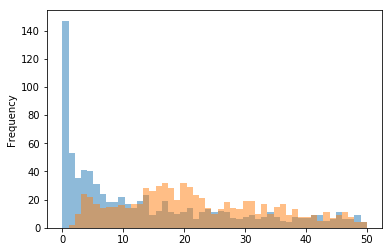

In [37]:
train_df.groupby('label')["duration"].plot(kind="hist", bins=np.linspace(0, 50), alpha=0.5)

In [38]:
CHUNK_TIME = 1 * CHUNK_FREQUENCY # number of terms per chunk

# Split on chunks

In [39]:
BATCH_SIZE = 32

- Get all file names, randomize them
- For each file - split on chunks, randomize them
- Get labels for each chunk

In [40]:
FFT_STEPS_NUM = 125

TODO:
- Fourier transform for chunk instead of full file

Как западить чанку нулями, и убрать их из лосса? Варианты:

### Удалять пустые чанки
3. Заменить в массиве data и events неполные чанки на зануленные
4. Добавить параметр mask, который отвечает за то, какие элементы функции потерь оставить
5. Заменить лосс


In [41]:
MAX_LENGTH = 300000

In [42]:
from scipy.signal import stft

In [43]:
# def get_fourier_transform(data, window_size=CHUNK_TIME, step_size=CHUNK_TIME // FFT_STEPS_NUM):
#     frequencies = []
#     for window in range(0, data.shape[0] - window_size, step_size):
#         chunk = data[window:window + window_size]
#         frequency_values = np.abs(np.fft.fft(chunk, axis=0))[:window_size // 2]
#         frequencies.append(frequency_values)
#     result = np.stack(frequencies)
#     return result

In [44]:
def get_fourier_transform(data, window_size=CHUNK_TIME, step_size=CHUNK_TIME // FFT_STEPS_NUM, SCALING_FACTOR=100):
    data = data.T
    return np.abs(stft(
        data, 
        fs=window_size, 
        window="hann", 
        nperseg=window_size, 
        noverlap=window_size - step_size, 
        return_onesided=True, 
        boundary=None,
    )[-1]).T * SCALING_FACTOR

In [45]:
def get_data(df, file, channels=CHANNELS, chunk_size=CHUNK_TIME, step_size=CHUNK_TIME // FFT_STEPS_NUM):
    annotations = df[
        (df["full_path"] == file) & \
        (df["label"] == "seiz")
    ][["start", "end"]]
    edf = mne.io.read_raw_edf(file, preload=True, verbose='ERROR')
    edf.filter(2, 60)
    edf_picks = edf.pick_channels(channels)
    data, time = edf_picks[:]
    
    events = time * 0
    for _, (start, end) in annotations.iterrows():
        events += (time >= start) & (time <= end)
    events = (events > 0).astype(int)
    
    del edf
    
    return data, events

In [46]:
def get_data_multiple(df, files, channels=CHANNELS, chunk_size=CHUNK_TIME):
    total_data = []
    total_events = []
    for file in tqdm_notebook(files):
        data, events = get_data(df, file)
        total_data.append(data)
        total_events.append(events)
    
    return total_data, total_events

In [47]:
class ChunksIterator():
    def __init__(self, data, events, chunk_size=CHUNK_TIME, step_size=CHUNK_TIME // FFT_STEPS_NUM, max_length=MAX_LENGTH, tqdm_enabled=False):
        self.data = data
        self.events = events
        self.chunk_size = chunk_size
        self.step_size = step_size
        self.valid_chunks = 0
        
        max_time = min(max([e.shape[0] for e in events]), max_length)
        self.iterations = range(0, max_time - 2*chunk_size, chunk_size)
        self.iterations = np.random.choice(self.iterations, len(self.iterations), replace=False)
        self.iterations_number = len(self.iterations)
        if tqdm_enabled:
            self.iterations = tqdm(self.iterations)
        self.iterations = iter(self.iterations)
    
    def __iter__(self):
        return self
    
    def __next__(self):
        data = self.data
        events = self.events
        chunk_size = self.chunk_size
        step_size = self.step_size
        chunk_start = next(self.iterations)
        
        data_chunk = [d[:, chunk_start:chunk_start + 2*chunk_size].T for d in data]
        labels_chunk = [e[chunk_start:chunk_start + chunk_size] for e in events]

        zero_data_chunk = np.zeros((chunk_size * 2, len(CHANNELS)))
        zero_labels_chunk = np.zeros((chunk_size, ))

        masks_chunk = [e.shape[0] == chunk_size for e in labels_chunk]
        data_chunk = [d if d.shape[0] == 2*chunk_size else zero_data_chunk for d in data_chunk]
        labels_chunk = [e if e.shape[0] == chunk_size else zero_labels_chunk for e in labels_chunk]

        data_chunk = [get_fourier_transform(d) for d in data_chunk]
        labels_chunk = [e.max() for e in labels_chunk]
        
        self.valid_chunks += sum(masks_chunk)

        return np.stack(data_chunk).reshape(len(data_chunk), -1), np.stack(labels_chunk)[:, np.newaxis], np.array(masks_chunk)

In [48]:
def iterate_files(df, batch_size=BATCH_SIZE):
    files = df["full_path"].unique()
    files = np.random.choice(files, len(files), replace=False)
    for files in zip(*[iter(files)]*batch_size):
        yield files

In [49]:
files = next(iterate_files(train_df))

In [50]:
data, events = get_data(train_df, files[0])

In [51]:
data.shape

(21, 334500)

In [52]:
files = train_df["full_path"].value_counts().index[0:BATCH_SIZE]
data, events = get_data_multiple(train_df, files)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [53]:
partial_lengths = [int(d.shape[1] * 0.005) for d in data]
partial_data = [d[:, :l] for d, l in zip(data, partial_lengths)]
partial_events = [e[:l] for e, l in zip(events, partial_lengths)]
min(partial_lengths)

384

In [54]:
iterator = ChunksIterator(partial_data, partial_events, tqdm_enabled=True)

print("Total iterations:", iterator.iterations_number)

for i, (data_chunk, labels_chunk, masks_chunk) in zip(range(10), iterator):
    print("Iteration {}".format(i), sum(masks_chunk))
    
print("Valid chunks:", iterator.valid_chunks)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Total iterations: 48
Iteration 0 1
Iteration 1 1
Iteration 2 1
Iteration 3 1
Iteration 4 17
Iteration 5 2
Iteration 6 5
Iteration 7 1
Iteration 8 1
Iteration 9 6
Valid chunks: 36


In [55]:
data_chunk.shape

(32, 333396)

# Model creation

In [56]:
NUM_EPOCHS = 10

In [57]:
import tensorflow as tf
from keras.layers import Dense,Activation,Dropout, Input, Conv1D, MaxPool1D, Flatten
from keras.layers import LSTM,Bidirectional,TimeDistributed #could try TimeDistributed(Dense(...))
from keras.models import Sequential, load_model
from keras import optimizers,regularizers
from keras.layers.normalization import BatchNormalization
import keras.backend.tensorflow_backend as KTF

In [59]:
eeg_input = Input(shape=((FFT_STEPS_NUM + 1) * (CHUNK_TIME // 2 + 1) * len(CHANNELS), ))

x = eeg_input
x = Dropout(0.5)(x)

for _ in range(3):
    x = Dense(100)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
events_output = Dense(1, activation='sigmoid')(x)

In [60]:
model = keras.models.Model(inputs=[eeg_input], outputs=[events_output])

In [61]:
s = tf.Session()

In [62]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [63]:
model.compile(
    loss="binary_crossentropy",
    optimizer='adam', 
    metrics=['accuracy', recall_m, precision_m]
)

# TODO Try to filter incomplete chunks

# Overfit on small dataset

TODO make model converge on this batch

In [64]:
generator = ChunksIterator(data, events)

In [65]:
for i in range(5):
    next(generator)
x_in, y_end, masks_in = next(generator)

In [66]:
y_end.sum() / (y_end > -1).sum()

0.40625

In [67]:
model.predict(x_in).mean()

0.5000591

In [68]:
model.evaluate(x_in, y_end)

32/32 [==============================] - 0s 8ms/step


[0.6931910514831543, 0.5, 1.0, 0.4482758641242981]

In [69]:
# model.fit(x_in, y_end, batch_size=x_in.shape[0], epochs=1000, sample_weight=masks_in)

In [70]:
y_end.sum()

13.0

RNN использовать можно и даже немного нужно
А вот seq2seq не надо - у вас же одинаковая длина входа и выхода. Имплементация будет очень похожа не языковую модельку, как была в последней домашке.

Если это исследования, а не в прод катить, я бы попробовал LMU и LSTM-SHA из реккурентных и Sparse Transformer

# Train model

In [71]:
GENERATOR_PAD_BUG = 1

In [72]:
total_train_history = {}
total_val_history = {}

for epoch in tqdm(range(10)):
    total_train_history[epoch] = []
    total_val_history[epoch] = []
    
    total_train_loss = 0
    total_train_chunks = 0
    
    total_val_loss = 0
    total_val_chunks = 0
    
    for train_files, val_files in tqdm_notebook(list(zip(iterate_files(train_df), iterate_files(val_df)))):
        # Training
        
        train_data, train_events = get_data_multiple(train_df, train_files)
        train_generator = ChunksIterator(train_data, train_events, tqdm_enabled=True)
        
        train_chunks = train_generator.iterations_number
        
        train_history = model.fit_generator(
            train_generator, 
            epochs=1, 
            steps_per_epoch=train_chunks - GENERATOR_PAD_BUG,
#             class_weight=[1, 10]
#             pickle_safe=False
        )
        
        total_train_loss += train_history.history['loss'][0] * train_generator.valid_chunks
        total_train_chunks += train_generator.valid_chunks
        
        model.reset_states()
        
        del train_generator
        del train_data
        del train_events
        
        # Validation
        
        val_data, val_events = get_data_multiple(val_df, val_files)
        val_generator = ChunksIterator(val_data, val_events, tqdm_enabled=True)
        
        val_chunks = val_generator.iterations_number
        
        val_metrics = model.evaluate_generator(
            val_generator,
            steps=val_chunks - GENERATOR_PAD_BUG
#             pickle_safe=False
        )
        
        print(val_metrics)
        
        total_val_loss += val_metrics[0] * val_generator.valid_chunks
        total_val_chunks += val_generator.valid_chunks
        
        model.reset_states()
        del val_generator
        del val_data
        del val_events
        
        total_train_history[epoch].append(total_train_loss / total_train_chunks)
        total_val_history[epoch].append(total_val_loss / total_val_chunks)
        
        print("Train loss:", total_train_history)
        print("Val loss:", total_val_history)
    
        model.save_weights("./models/fc-fft-model-{}.h5".format(epoch))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Instructions for updating:
Use tf.cast instead.
Epoch 1/1
1197/1197 [==============================] - 537s 449ms/step - loss: 0.2362 - acc: 0.9187 - recall_m: 0.7108 - precision_m: 0.7797



[1.1149410669479454, 0.8290517961570593, 0.26904065397847365, 0.26524400845506135]

Train loss: {0: [0.2361573862011483]}
Val loss: {0: [1.1149410669479454]}


Epoch 1/1
1197/1197 [==============================] - 502s 420ms/step - loss: 0.2412 - acc: 0.9398 - recall_m: 0.7144 - precision_m: 0.8068



[1.335201656086403, 0.7640455304928989, 0.08303404026785391, 0.09707337264329469]

Train loss: {0: [0.2361573862011483, 0.23856229832452375]}
Val loss: {0: [1.1149410669479454, 1.2187083615615215]}


Epoch 1/1
1197/1197 [==============================] - 563s 470ms/step - loss: 0.1998 - acc: 0.9022 - recall_m: 0.8398 - precision_m: 0.8681



[1.025184989896733, 0.8181129908103593, 0.047326650604319356, 0.10930401237437201]

Train loss: {0: [0.2361573862011483, 0.23856229832452375, 0.2261950676948891]}
Val loss: {0: [1.1149410669479454, 1.2187083615615215, 1.1516902665810886]}


Epoch 1/1
1197/1197 [==============================] - 604s 505ms/step - loss: 0.2692 - acc: 0.8273 - recall_m: 0.6336 - precision_m: 0.6819



[0.8681122250170288, 0.7943034670008354, 0.13561114668223692, 0.2630315783652247]

Train loss: {0: [0.2361573862011483, 0.23856229832452375, 0.2261950676948891, 0.2382433125299084]}
Val loss: {0: [1.1149410669479454, 1.2187083615615215, 1.1516902665810886, 1.079907613495068]}


Epoch 1/1
1197/1197 [==============================] - 618s 516ms/step - loss: 0.2355 - acc: 0.9238 - recall_m: 0.7792 - precision_m: 0.8571



[0.7321695277191941, 0.8172514619883041, 0.3688546182430577, 0.3695034918156682]

Train loss: {0: [0.2361573862011483, 0.23856229832452375, 0.2261950676948891, 0.2382433125299084, 0.23771040256692902]}
Val loss: {0: [1.1149410669479454, 1.2187083615615215, 1.1516902665810886, 1.079907613495068, 1.009567661918911]}


Epoch 1/1
1197/1197 [==============================] - 543s 454ms/step - loss: 0.3349 - acc: 0.9039 - recall_m: 0.6183 - precision_m: 0.7016



[1.0113819528343087, 0.806234335839599, 0.06908241096719066, 0.3583959610689254]

Train loss: {0: [0.2361573862011483, 0.23856229832452375, 0.2261950676948891, 0.2382433125299084, 0.23771040256692902, 0.2524838845717164]}
Val loss: {0: [1.1149410669479454, 1.2187083615615215, 1.1516902665810886, 1.079907613495068, 1.009567661918911, 1.009873473328366]}



Epoch 1/1
1197/1197 [==============================] - 603s 504ms/step - loss: 0.2304 - acc: 0.9192 - recall_m: 0.4458 - precision_m: 0.5501



[1.354112869771252, 0.8447159565580619, 0.048403446997516635, 0.19270396329705278]

Train loss: {0: [0.2361573862011483, 0.23856229832452375, 0.2261950676948891, 0.2382433125299084, 0.23771040256692902, 0.2524838845717164], 1: [0.23035201998370616]}
Val loss: {0: [1.1149410669479454, 1.2187083615615215, 1.1516902665810886, 1.079907613495068, 1.009567661918911, 1.009873473328366], 1: [1.354112869771252]}


Epoch 1/1
1197/1197 [==============================] - 527s 440ms/step - loss: 0.2035 - acc: 0.9464 - recall_m: 0.8712 - precision_m: 0.9194



[0.4832858138888103, 0.8628341687552213, 0.5898283812635225, 0.7103002281889083]

Train loss: {0: [0.2361573862011483, 0.23856229832452375, 0.2261950676948891, 0.2382433125299084, 0.23771040256692902, 0.2524838845717164], 1: [0.23035201998370616, 0.2168626630380002]}
Val loss: {0: [1.1149410669479454, 1.2187083615615215, 1.1516902665810886, 1.079907613495068, 1.009567661918911, 1.009873473328366], 1: [1.354112869771252, 0.9011968234290089]}


Epoch 1/1
1197/1197 [==============================] - 637s 533ms/step - loss: 0.1796 - acc: 0.8268 - recall_m: 0.8190 - precision_m: 0.7156



[0.5470685884761083, 0.8626775271512114, 0.4749269306522762, 0.625481357973819]

Train loss: {0: [0.2361573862011483, 0.23856229832452375, 0.2261950676948891, 0.2382433125299084, 0.23771040256692902, 0.2524838845717164], 1: [0.23035201998370616, 0.2168626630380002, 0.2041753391928416]}
Val loss: {0: [1.1149410669479454, 1.2187083615615215, 1.1516902665810886, 1.079907613495068, 1.009567661918911, 1.009873473328366], 1: [1.354112869771252, 0.9011968234290089, 0.7899874809198136]}


Epoch 1/1
1197/1197 [==============================] - 553s 462ms/step - loss: 0.2836 - acc: 0.9321 - recall_m: 0.6476 - precision_m: 0.7882



[0.6889267647895673, 0.8264672096908939, 0.1262440280358594, 0.20150375267865764]

Train loss: {0: [0.2361573862011483, 0.23856229832452375, 0.2261950676948891, 0.2382433125299084, 0.23771040256692902, 0.2524838845717164], 1: [0.23035201998370616, 0.2168626630380002, 0.2041753391928416, 0.2236131622332076]}
Val loss: {0: [1.1149410669479454, 1.2187083615615215, 1.1516902665810886, 1.079907613495068, 1.009567661918911, 1.009873473328366], 1: [1.354112869771252, 0.9011968234290089, 0.7899874809198136, 0.7660672695691504]}


Epoch 1/1
1197/1197 [==============================] - 639s 534ms/step - loss: 0.2401 - acc: 0.9017 - recall_m: 0.8147 - precision_m: 0.8335



[0.6690106494546734, 0.8335160818713451, 0.31483290350701076, 0.4258463598955843]

Train loss: {0: [0.2361573862011483, 0.23856229832452375, 0.2261950676948891, 0.2382433125299084, 0.23771040256692902, 0.2524838845717164], 1: [0.23035201998370616, 0.2168626630380002, 0.2041753391928416, 0.2236131622332076, 0.22727207177057696]}
Val loss: {0: [1.1149410669479454, 1.2187083615615215, 1.1516902665810886, 1.079907613495068, 1.009567661918911, 1.009873473328366], 1: [1.354112869771252, 0.9011968234290089, 0.7899874809198136, 0.7660672695691504, 0.7464858868677067]}


Epoch 1/1
1197/1197 [==============================] - 519s 433ms/step - loss: 0.2509 - acc: 0.9316 - recall_m: 0.8045 - precision_m: 0.9176



[0.7179131050381744, 0.8662280701754386, 0.049145682631628454, 0.1668755096650263]

Train loss: {0: [0.2361573862011483, 0.23856229832452375, 0.2261950676948891, 0.2382433125299084, 0.23771040256692902, 0.2524838845717164], 1: [0.23035201998370616, 0.2168626630380002, 0.2041753391928416, 0.2236131622332076, 0.22727207177057696, 0.231007462279489]}
Val loss: {0: [1.1149410669479454, 1.2187083615615215, 1.1516902665810886, 1.079907613495068, 1.009567661918911, 1.009873473328366], 1: [1.354112869771252, 0.9011968234290089, 0.7899874809198136, 0.7660672695691504, 0.7464858868677067, 0.742371076266351]}



Epoch 1/1
1197/1197 [==============================] - 548s 458ms/step - loss: 0.2338 - acc: 0.8604 - recall_m: 0.5246 - precision_m: 0.5780



[0.6464427594148375, 0.8184784878863827, 0.22038812386362175, 0.34901936143113854]

Train loss: {0: [0.2361573862011483, 0.23856229832452375, 0.2261950676948891, 0.2382433125299084, 0.23771040256692902, 0.2524838845717164], 1: [0.23035201998370616, 0.2168626630380002, 0.2041753391928416, 0.2236131622332076, 0.22727207177057696, 0.231007462279489], 2: [0.23379658007271292]}
Val loss: {0: [1.1149410669479454, 1.2187083615615215, 1.1516902665810886, 1.079907613495068, 1.009567661918911, 1.009873473328366], 1: [1.354112869771252, 0.9011968234290089, 0.7899874809198136, 0.7660672695691504, 0.7464858868677067, 0.742371076266351], 2: [0.6464427594148375]}


Epoch 1/1
1197/1197 [==============================] - 525s 439ms/step - loss: 0.3079 - acc: 0.8348 - recall_m: 0.7524 - precision_m: 0.7272



[0.7412117234102094, 0.8495718462823726, 0.014742059983257064, 0.10073794739487377]

Train loss: {0: [0.2361573862011483, 0.23856229832452375, 0.2261950676948891, 0.2382433125299084, 0.23771040256692902, 0.2524838845717164], 1: [0.23035201998370616, 0.2168626630380002, 0.2041753391928416, 0.2236131622332076, 0.22727207177057696, 0.231007462279489], 2: [0.23379658007271292, 0.2736394389034812]}
Val loss: {0: [1.1149410669479454, 1.2187083615615215, 1.1516902665810886, 1.079907613495068, 1.009567661918911, 1.009873473328366], 1: [1.354112869771252, 0.9011968234290089, 0.7899874809198136, 0.7660672695691504, 0.7464858868677067, 0.742371076266351], 2: [0.6464427594148375, 0.6933274583567852]}


Epoch 1/1
1197/1197 [==============================] - 610s 509ms/step - loss: 0.2275 - acc: 0.9193 - recall_m: 0.7519 - precision_m: 0.7902



[1.0740633322083164, 0.737390350877193, 0.24131210380503806, 0.5191268521480095]

Train loss: {0: [0.2361573862011483, 0.23856229832452375, 0.2261950676948891, 0.2382433125299084, 0.23771040256692902, 0.2524838845717164], 1: [0.23035201998370616, 0.2168626630380002, 0.2041753391928416, 0.2236131622332076, 0.22727207177057696, 0.231007462279489], 2: [0.23379658007271292, 0.2736394389034812, 0.25693924840018867]}
Val loss: {0: [1.1149410669479454, 1.2187083615615215, 1.1516902665810886, 1.079907613495068, 1.009567661918911, 1.009873473328366], 1: [1.354112869771252, 0.9011968234290089, 0.7899874809198136, 0.7660672695691504, 0.7464858868677067, 0.742371076266351], 2: [0.6464427594148375, 0.6933274583567852, 0.8246800063782227]}


Epoch 1/1
1197/1197 [==============================] - 622s 520ms/step - loss: 0.2267 - acc: 0.9304 - recall_m: 0.7780 - precision_m: 0.8719



[0.8707577599867643, 0.7792136591478697, 0.23141020800336362, 0.3388600708510643]

Train loss: {0: [0.2361573862011483, 0.23856229832452375, 0.2261950676948891, 0.2382433125299084, 0.23771040256692902, 0.2524838845717164], 1: [0.23035201998370616, 0.2168626630380002, 0.2041753391928416, 0.2236131622332076, 0.22727207177057696, 0.231007462279489], 2: [0.23379658007271292, 0.2736394389034812, 0.25693924840018867, 0.2484234035016144]}
Val loss: {0: [1.1149410669479454, 1.2187083615615215, 1.1516902665810886, 1.079907613495068, 1.009567661918911, 1.009873473328366], 1: [1.354112869771252, 0.9011968234290089, 0.7899874809198136, 0.7660672695691504, 0.7464858868677067, 0.742371076266351], 2: [0.6464427594148375, 0.6933274583567852, 0.8246800063782227, 0.8367447682178258]}


Epoch 1/1
1197/1197 [==============================] - 605s 505ms/step - loss: 0.2188 - acc: 0.9445 - recall_m: 0.8327 - precision_m: 0.8701



[0.5684475661967332, 0.8515559732664996, 0.31410229510457294, 0.4093291966389295]

Train loss: {0: [0.2361573862011483, 0.23856229832452375, 0.2261950676948891, 0.2382433125299084, 0.23771040256692902, 0.2524838845717164], 1: [0.23035201998370616, 0.2168626630380002, 0.2041753391928416, 0.2236131622332076, 0.22727207177057696, 0.231007462279489], 2: [0.23379658007271292, 0.2736394389034812, 0.25693924840018867, 0.2484234035016144, 0.24292647648257726]}
Val loss: {0: [1.1149410669479454, 1.2187083615615215, 1.1516902665810886, 1.079907613495068, 1.009567661918911, 1.009873473328366], 1: [1.354112869771252, 0.9011968234290089, 0.7899874809198136, 0.7660672695691504, 0.7464858868677067, 0.742371076266351], 2: [0.6464427594148375, 0.6933274583567852, 0.8246800063782227, 0.8367447682178258, 0.7819647831239384]}


Epoch 1/1
1197/1197 [==============================] - 596s 498ms/step - loss: 0.2029 - acc: 0.9079 - recall_m: 0.6719 - precision_m: 0.7211



[0.6443930140065469, 0.8264933166248956, 0.13519549174988976, 0.17256301798940998]

Train loss: {0: [0.2361573862011483, 0.23856229832452375, 0.2261950676948891, 0.2382433125299084, 0.23771040256692902, 0.2524838845717164], 1: [0.23035201998370616, 0.2168626630380002, 0.2041753391928416, 0.2236131622332076, 0.22727207177057696, 0.231007462279489], 2: [0.23379658007271292, 0.2736394389034812, 0.25693924840018867, 0.2484234035016144, 0.24292647648257726, 0.2355383809522293]}
Val loss: {0: [1.1149410669479454, 1.2187083615615215, 1.1516902665810886, 1.079907613495068, 1.009567661918911, 1.009873473328366], 1: [1.354112869771252, 0.9011968234290089, 0.7899874809198136, 0.7660672695691504, 0.7464858868677067, 0.742371076266351], 2: [0.6464427594148375, 0.6933274583567852, 0.8246800063782227, 0.8367447682178258, 0.7819647831239384, 0.7622702535194942]}



Epoch 1/1
1197/1197 [==============================] - 610s 509ms/step - loss: 0.2266 - acc: 0.9332 - recall_m: 0.7899 - precision_m: 0.8772



[0.5033647662764703, 0.8505378028404345, 0.6972779812619601, 0.7107322690082573]

Train loss: {0: [0.2361573862011483, 0.23856229832452375, 0.2261950676948891, 0.2382433125299084, 0.23771040256692902, 0.2524838845717164], 1: [0.23035201998370616, 0.2168626630380002, 0.2041753391928416, 0.2236131622332076, 0.22727207177057696, 0.231007462279489], 2: [0.23379658007271292, 0.2736394389034812, 0.25693924840018867, 0.2484234035016144, 0.24292647648257726, 0.2355383809522293], 3: [0.22655312602665764]}
Val loss: {0: [1.1149410669479454, 1.2187083615615215, 1.1516902665810886, 1.079907613495068, 1.009567661918911, 1.009873473328366], 1: [1.354112869771252, 0.9011968234290089, 0.7899874809198136, 0.7660672695691504, 0.7464858868677067, 0.742371076266351], 2: [0.6464427594148375, 0.6933274583567852, 0.8246800063782227, 0.8367447682178258, 0.7819647831239384, 0.7622702535194942], 3: [0.5033647662764703]}


Epoch 1/1
1197/1197 [==============================] - 606s 506ms/step - loss: 0.2967 - acc: 0.9203 - recall_m: 0.6356 - precision_m: 0.8348



[0.7710012413604915, 0.7258510860484545, 0.6638522353661289, 0.2660736751461786]

Train loss: {0: [0.2361573862011483, 0.23856229832452375, 0.2261950676948891, 0.2382433125299084, 0.23771040256692902, 0.2524838845717164], 1: [0.23035201998370616, 0.2168626630380002, 0.2041753391928416, 0.2236131622332076, 0.22727207177057696, 0.231007462279489], 2: [0.23379658007271292, 0.2736394389034812, 0.25693924840018867, 0.2484234035016144, 0.24292647648257726, 0.2355383809522293], 3: [0.22655312602665764, 0.2630475089064923]}
Val loss: {0: [1.1149410669479454, 1.2187083615615215, 1.1516902665810886, 1.079907613495068, 1.009567661918911, 1.009873473328366], 1: [1.354112869771252, 0.9011968234290089, 0.7899874809198136, 0.7660672695691504, 0.7464858868677067, 0.742371076266351], 2: [0.6464427594148375, 0.6933274583567852, 0.8246800063782227, 0.8367447682178258, 0.7819647831239384, 0.7622702535194942], 3: [0.5033647662764703, 0.6312323101672485]}


Epoch 1/1
1197/1197 [==============================] - 555s 464ms/step - loss: 0.1572 - acc: 0.9145 - recall_m: 0.7922 - precision_m: 0.7976



[0.8178145506402903, 0.8368838763575606, 0.17531364989360373, 0.35369972075485845]

Train loss: {0: [0.2361573862011483, 0.23856229832452375, 0.2261950676948891, 0.2382433125299084, 0.23771040256692902, 0.2524838845717164], 1: [0.23035201998370616, 0.2168626630380002, 0.2041753391928416, 0.2236131622332076, 0.22727207177057696, 0.231007462279489], 2: [0.23379658007271292, 0.2736394389034812, 0.25693924840018867, 0.2484234035016144, 0.24292647648257726, 0.2355383809522293], 3: [0.22655312602665764, 0.2630475089064923, 0.22928873814129624]}
Val loss: {0: [1.1149410669479454, 1.2187083615615215, 1.1516902665810886, 1.079907613495068, 1.009567661918911, 1.009873473328366], 1: [1.354112869771252, 0.9011968234290089, 0.7899874809198136, 0.7660672695691504, 0.7464858868677067, 0.742371076266351], 2: [0.6464427594148375, 0.6933274583567852, 0.8246800063782227, 0.8367447682178258, 0.7819647831239384, 0.7622702535194942], 3: [0.5033647662764703, 0.6312323101672485, 0.6938219776037882]}


Epoch 1/1
1197/1197 [==============================] - 597s 499ms/step - loss: 0.1800 - acc: 0.9125 - recall_m: 0.8589 - precision_m: 0.8546



[1.4015346384088299, 0.7920843776106934, 0.0262921213630646, 0.05930103087733961]

Train loss: {0: [0.2361573862011483, 0.23856229832452375, 0.2261950676948891, 0.2382433125299084, 0.23771040256692902, 0.2524838845717164], 1: [0.23035201998370616, 0.2168626630380002, 0.2041753391928416, 0.2236131622332076, 0.22727207177057696, 0.231007462279489], 2: [0.23379658007271292, 0.2736394389034812, 0.25693924840018867, 0.2484234035016144, 0.24292647648257726, 0.2355383809522293], 3: [0.22655312602665764, 0.2630475089064923, 0.22928873814129624, 0.21643034968691877]}
Val loss: {0: [1.1149410669479454, 1.2187083615615215, 1.1516902665810886, 1.079907613495068, 1.009567661918911, 1.009873473328366], 1: [1.354112869771252, 0.9011968234290089, 0.7899874809198136, 0.7660672695691504, 0.7464858868677067, 0.742371076266351], 2: [0.6464427594148375, 0.6933274583567852, 0.8246800063782227, 0.8367447682178258, 0.7819647831239384, 0.7622702535194942], 3: [0.5033647662764703, 0.6312323101672485, 0.69382197

Epoch 1/1
1197/1197 [==============================] - 557s 465ms/step - loss: 0.2017 - acc: 0.9421 - recall_m: 0.6913 - precision_m: 0.7602



[0.6319801297751485, 0.8500939849624061, 0.3952991005372483, 0.48189322655412087]

Train loss: {0: [0.2361573862011483, 0.23856229832452375, 0.2261950676948891, 0.2382433125299084, 0.23771040256692902, 0.2524838845717164], 1: [0.23035201998370616, 0.2168626630380002, 0.2041753391928416, 0.2236131622332076, 0.22727207177057696, 0.231007462279489], 2: [0.23379658007271292, 0.2736394389034812, 0.25693924840018867, 0.2484234035016144, 0.24292647648257726, 0.2355383809522293], 3: [0.22655312602665764, 0.2630475089064923, 0.22928873814129624, 0.21643034968691877, 0.21335759745233623]}
Val loss: {0: [1.1149410669479454, 1.2187083615615215, 1.1516902665810886, 1.079907613495068, 1.009567661918911, 1.009873473328366], 1: [1.354112869771252, 0.9011968234290089, 0.7899874809198136, 0.7660672695691504, 0.7464858868677067, 0.742371076266351], 2: [0.6464427594148375, 0.6933274583567852, 0.8246800063782227, 0.8367447682178258, 0.7819647831239384, 0.7622702535194942], 3: [0.5033647662764703, 0.6312323

Epoch 1/1
1197/1197 [==============================] - 603s 504ms/step - loss: 0.1840 - acc: 0.9505 - recall_m: 0.6009 - precision_m: 0.6670



[0.4943365632690981, 0.8731203007518797, 0.14745645177742792, 0.4616541170585922]

Train loss: {0: [0.2361573862011483, 0.23856229832452375, 0.2261950676948891, 0.2382433125299084, 0.23771040256692902, 0.2524838845717164], 1: [0.23035201998370616, 0.2168626630380002, 0.2041753391928416, 0.2236131622332076, 0.22727207177057696, 0.231007462279489], 2: [0.23379658007271292, 0.2736394389034812, 0.25693924840018867, 0.2484234035016144, 0.24292647648257726, 0.2355383809522293], 3: [0.22655312602665764, 0.2630475089064923, 0.22928873814129624, 0.21643034968691877, 0.21335759745233623, 0.20853233960338707]}
Val loss: {0: [1.1149410669479454, 1.2187083615615215, 1.1516902665810886, 1.079907613495068, 1.009567661918911, 1.009873473328366], 1: [1.354112869771252, 0.9011968234290089, 0.7899874809198136, 0.7660672695691504, 0.7464858868677067, 0.742371076266351], 2: [0.6464427594148375, 0.6933274583567852, 0.8246800063782227, 0.8367447682178258, 0.7819647831239384, 0.7622702535194942], 3: [0.503364

Epoch 1/1
1197/1197 [==============================] - 568s 474ms/step - loss: 0.2327 - acc: 0.9392 - recall_m: 0.8327 - precision_m: 0.8700



[0.7962908565798897, 0.7409147869674185, 0.43338927544448014, 0.3996433187945246]

Train loss: {0: [0.2361573862011483, 0.23856229832452375, 0.2261950676948891, 0.2382433125299084, 0.23771040256692902, 0.2524838845717164], 1: [0.23035201998370616, 0.2168626630380002, 0.2041753391928416, 0.2236131622332076, 0.22727207177057696, 0.231007462279489], 2: [0.23379658007271292, 0.2736394389034812, 0.25693924840018867, 0.2484234035016144, 0.24292647648257726, 0.2355383809522293], 3: [0.22655312602665764, 0.2630475089064923, 0.22928873814129624, 0.21643034968691877, 0.21335759745233623, 0.20853233960338707], 4: [0.2327172604409718]}
Val loss: {0: [1.1149410669479454, 1.2187083615615215, 1.1516902665810886, 1.079907613495068, 1.009567661918911, 1.009873473328366], 1: [1.354112869771252, 0.9011968234290089, 0.7899874809198136, 0.7660672695691504, 0.7464858868677067, 0.742371076266351], 2: [0.6464427594148375, 0.6933274583567852, 0.8246800063782227, 0.8367447682178258, 0.7819647831239384, 0.762270

Epoch 1/1
1197/1197 [==============================] - 588s 491ms/step - loss: 0.2093 - acc: 0.9615 - recall_m: 0.7935 - precision_m: 0.9029



[0.489739242807317, 0.8575344611528822, 0.23809948896579974, 0.4105992416167319]

Train loss: {0: [0.2361573862011483, 0.23856229832452375, 0.2261950676948891, 0.2382433125299084, 0.23771040256692902, 0.2524838845717164], 1: [0.23035201998370616, 0.2168626630380002, 0.2041753391928416, 0.2236131622332076, 0.22727207177057696, 0.231007462279489], 2: [0.23379658007271292, 0.2736394389034812, 0.25693924840018867, 0.2484234035016144, 0.24292647648257726, 0.2355383809522293], 3: [0.22655312602665764, 0.2630475089064923, 0.22928873814129624, 0.21643034968691877, 0.21335759745233623, 0.20853233960338707], 4: [0.2327172604409718, 0.22203397155316015]}
Val loss: {0: [1.1149410669479454, 1.2187083615615215, 1.1516902665810886, 1.079907613495068, 1.009567661918911, 1.009873473328366], 1: [1.354112869771252, 0.9011968234290089, 0.7899874809198136, 0.7660672695691504, 0.7464858868677067, 0.742371076266351], 2: [0.6464427594148375, 0.6933274583567852, 0.8246800063782227, 0.8367447682178258, 0.781964

Epoch 1/1
 644/1197 [===============>..............] - ETA: 3:58 - loss: 0.1888 - acc: 0.9551 - recall_m: 0.8631 - precision_m: 0.9416



KeyboardInterrupt: 

Масштаб данных был увеличен, и это сильно улучшило качество модели. Что произойдет, если в самом начале скалировать данные? Что произойдет, если использовать логарифм амплитуды?

In [73]:
plt.plot([train_losses[k][-1] for k in range(5)])
plt.plot([val_losses[k][-1] for k in range(5)])

NameError: name 'train_losses' is not defined

In [76]:
model.save_weights("./models/fc-fft-model-test.h5")

In [78]:
# model.load_weights("./models/cnn-lstm-fft-model-9.h5")

# Prediction

In [74]:
test_files = next(iterate_files(val_df))

In [75]:
test_data, test_events = get_data_multiple(val_df, test_files)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [77]:
class TestGenerator():
    def __init__(self, data, events):
        self.events = []
        self.generator = ChunksIterator(data, events, tqdm_enabled=False)
        self.generator.iterations = iter(tqdm(list(sorted(self.generator.iterations))))
    
    def __iter__(self):
        return self
    
    def __next__(self):
        data_chunk, events_chunk, masks_chunk = next(self.generator)
        self.events.append(events_chunk)
        return data_chunk, events_chunk

In [78]:
model.reset_states()

test_generator = TestGenerator(test_data, test_events)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [79]:
prediction = model.predict_generator(
    test_generator,
    test_generator.generator.iterations_number
)

In [80]:
all_true_events = np.stack(test_generator.events)

In [81]:
all_predicted_events = prediction.reshape(*all_true_events.shape)

In [82]:
(all_true_events > 0.5).sum() / (all_true_events > -1).sum()

0.1404424040066778

In [83]:
all_predicted_events[all_true_events > 0.5].mean()

0.6207539

In [84]:
all_predicted_events[all_true_events < 0.5].mean()

0.33659124

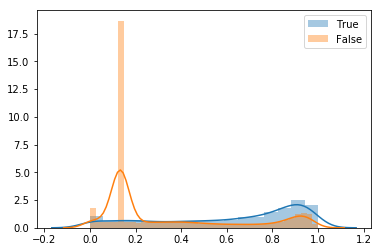

In [85]:
sns.distplot(all_predicted_events[all_true_events > 0.5], label="True")
sns.distplot(all_predicted_events[all_true_events < 0.5], label="False")
plt.legend()

In [86]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [87]:
min_seizure_duration = 10 * CHUNK_FREQUENCY

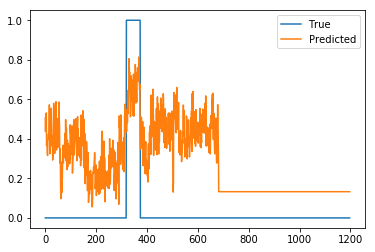

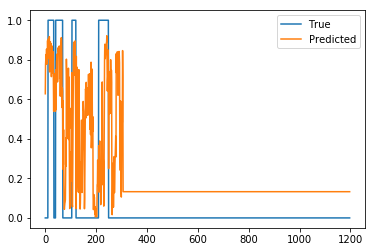

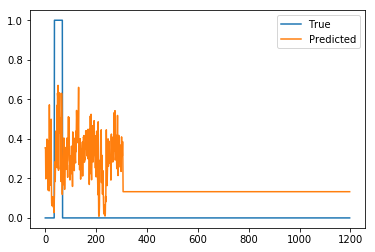

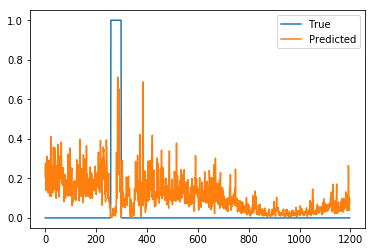

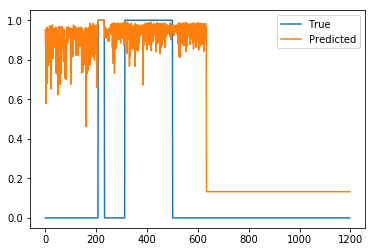

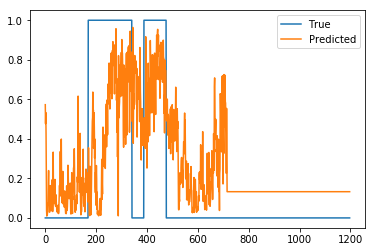

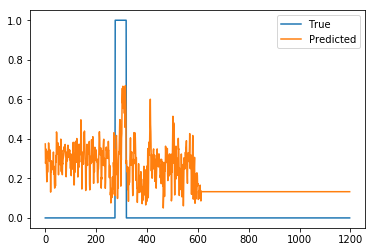

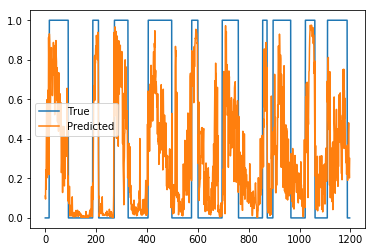

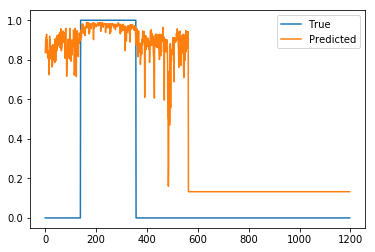

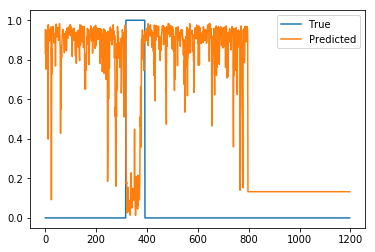

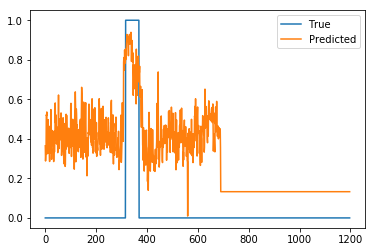

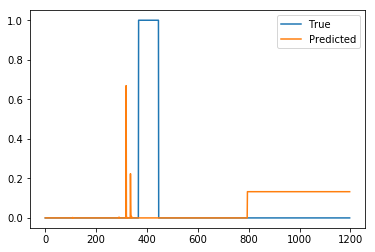

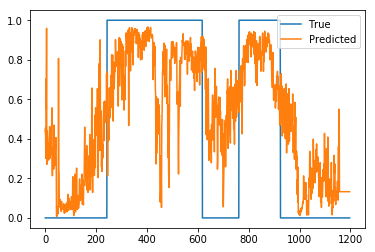

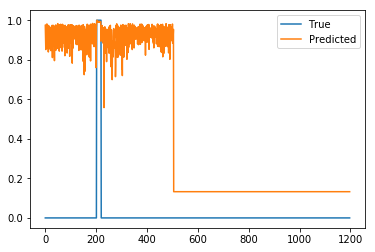

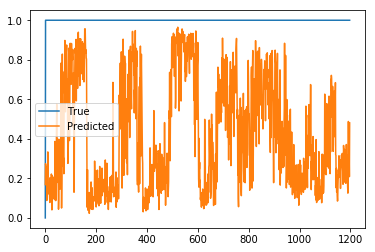

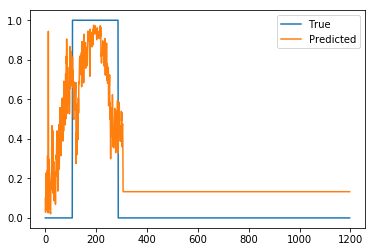

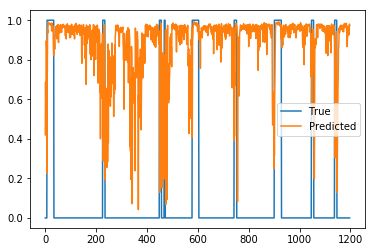

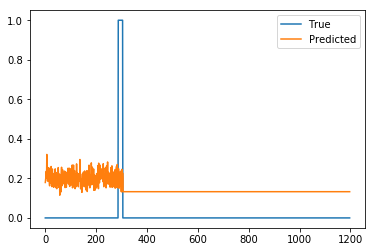

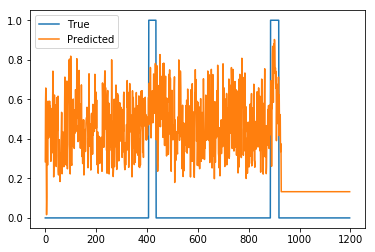

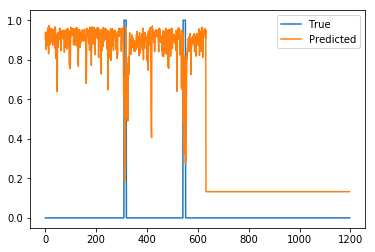

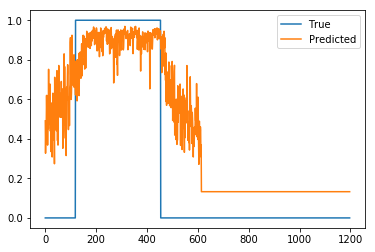

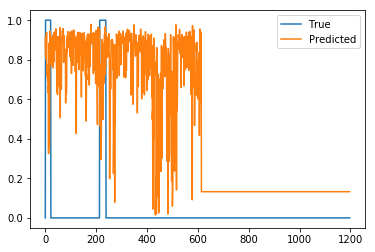

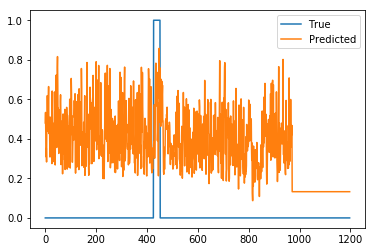

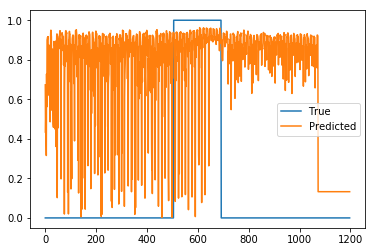

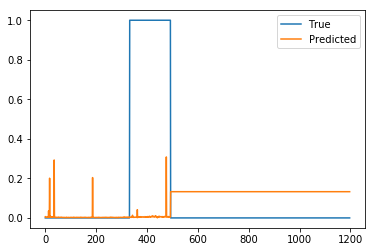

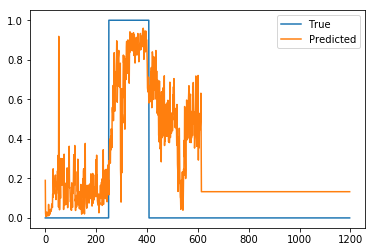

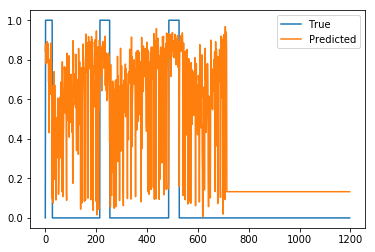

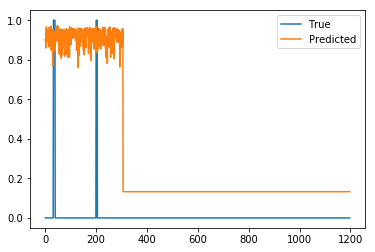

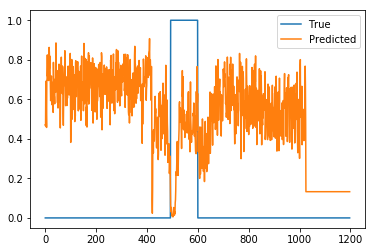

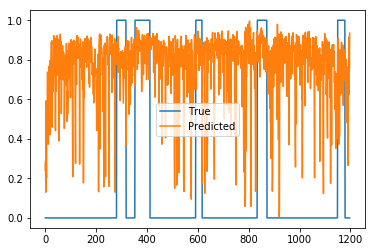

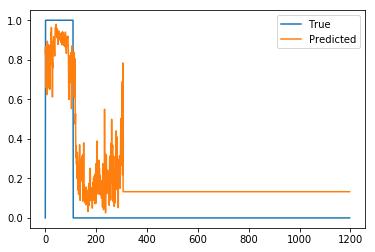

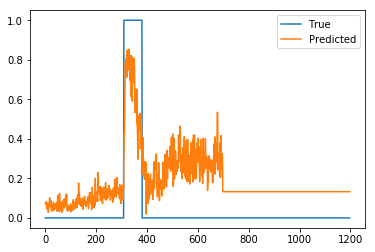

In [88]:
for series in range(32):
    true_events_line = all_true_events[:, series, :].reshape(-1)
    predicted_events_line = all_predicted_events[:, series, :].reshape(-1)
    smoothed_events_line = (moving_average(predicted_events_line, n=min_seizure_duration) > 0.3).astype(int)
    plt.plot(true_events_line, label="True")
    plt.plot(predicted_events_line, label="Predicted")
#     plt.plot(smoothed_events_line, label="Smoothed")
    plt.legend()
    plt.show()

# Heuristic smoothing

0. Merging events
1. Probabilistic filtering 
2. Duration filtering
3. Target aggregation

In [41]:
def merging_events(y_pred, threshold=0.5):
    events = []
    prev_class = "bckg"
    curr_class = None
    event_start = 0
        
    for index, value in enumerate(y_pred):
        if (value > 0.5):
            curr_class = "seiz"
        else:
            curr_class = "bckg"
            
        if prev_class != curr_class:
            event = {
                "start": event_start,
                "end": index,
                "class": prev_class,
                "probability": y_pred[event_start:index].mean()
            }
            prev_class = curr_class
            event_start = index
            events.append(event)
            
    event = {
        "start": event_start,
        "end": index,
        "class": prev_class,
        "probability": y_pred[event_start:index].mean()
    }
    events.append(event)
        
    return events

In [42]:
def probabilistic_filtering(events, threshold=0.75):
    new_events = []
    skip_next = False
    
    for index, event in enumerate(events):
        if skip_next:
            skip_next = False
            continue
        elif (event["class"] == "seiz") and (event["probability"] < threshold):
            previous_event = new_events[-1]
            next_event = events[index + 1]
            new_event = previous_event
            new_event["end"] = next_event["end"]
            new_event["probability"] = (next_event["probability"] + previous_event["probability"]) / 2
            skip_next = True
        else:
            new_events.append(event)
            
    return new_events

In [43]:
def duration_filtering(events, threshold=3):
    new_events = []
    skip_next = False
    
    for index, event in enumerate(events):
        if skip_next:
            skip_next = False
            continue
        elif (event["class"] == "seiz") and ((event["end"] - event["start"]) < threshold):
            previous_event = new_events[-1]
            next_event = events[index + 1]
            print(previous_event, next_event)
            new_event = previous_event
            new_event["end"] = next_event["end"]
            new_event["probability"] = (next_event["probability"] + previous_event["probability"]) / 2
            skip_next = True
        else:
            new_events.append(event)
    
    return new_events

In [56]:
def target_aggregation(events, margin=3.54):
    new_events = []
    skip_next = False
    
    for index, event in enumerate(events):
        if skip_next:
            skip_next = False
            continue
        elif (event["class"] == "bckg") and ((event["end"] - event["start"]) < margin) and (index > 0):
            previous_event = new_events[-1]
            next_event = events[index + 1]
            
            new_event = previous_event
            new_event["end"] = next_event["end"]
            new_event["probability"] = (next_event["probability"] + previous_event["probability"]) / 2
            skip_next = True
        else:
            new_events.append(event)
    
    return new_events

In [57]:
events = [{
    'class': 'bckg',
    'start': 0,
    'end': 2,
    'probability': 0.91
}, {
    'class': 'seiz',
    'start': 2,
    'end': 5,
    'probability': 0.97
}, {
    'class': 'bckg',
    'start': 5,
    'end': 10,
    'probability': 0.88
}, {
    'class': 'seiz',
    'start': 10,
    'end': 22,
    'probability': 0.77
}, {
    'class': 'bckg',
    'start': 22,
    'end': 24,
    'probability': 0.82
}, {
    'class': 'seiz',
    'start': 24,
    'end': 28,
    'probability': 0.87
}, {
    'class': 'bckg',
    'start': 28,
    'end': 32,
    'probability': 0.61
}, {
    'class': 'seiz',
    'start': 32,
    'end': 37,
    'probability': 0.57
}, {
    'class': 'bckg',
    'start': 37,
    'end': 42,
    'probability': 0.72
}, {
    'class': 'seiz',
    'start': 42,
    'end': 43,
    'probability': 0.9
}, {
    'class': 'bckg',
    'start': 43,
    'end': 45,
    'probability': 0.6
}]

for event in events:
    if event["class"] == "bckg":
        event["probability"] = 1 - event["probability"]

In [58]:
# events = merging_events(predicted_events_line)
events

[{'class': 'bckg', 'end': 2, 'probability': 0.08999999999999997, 'start': 0},
 {'class': 'seiz', 'end': 5, 'probability': 0.97, 'start': 2},
 {'class': 'bckg', 'end': 10, 'probability': 0.12, 'start': 5},
 {'class': 'seiz', 'end': 22, 'probability': 0.77, 'start': 10},
 {'class': 'bckg', 'end': 24, 'probability': 0.18000000000000005, 'start': 22},
 {'class': 'seiz', 'end': 28, 'probability': 0.87, 'start': 24},
 {'class': 'bckg', 'end': 32, 'probability': 0.39, 'start': 28},
 {'class': 'seiz', 'end': 37, 'probability': 0.57, 'start': 32},
 {'class': 'bckg', 'end': 42, 'probability': 0.28, 'start': 37},
 {'class': 'seiz', 'end': 43, 'probability': 0.9, 'start': 42},
 {'class': 'bckg', 'end': 45, 'probability': 0.4, 'start': 43}]

In [59]:
events = probabilistic_filtering(events)
events

[{'class': 'bckg', 'end': 2, 'probability': 0.08999999999999997, 'start': 0},
 {'class': 'seiz', 'end': 5, 'probability': 0.97, 'start': 2},
 {'class': 'bckg', 'end': 10, 'probability': 0.12, 'start': 5},
 {'class': 'seiz', 'end': 22, 'probability': 0.77, 'start': 10},
 {'class': 'bckg', 'end': 24, 'probability': 0.18000000000000005, 'start': 22},
 {'class': 'seiz', 'end': 28, 'probability': 0.87, 'start': 24},
 {'class': 'bckg', 'end': 42, 'probability': 0.335, 'start': 28},
 {'class': 'seiz', 'end': 43, 'probability': 0.9, 'start': 42},
 {'class': 'bckg', 'end': 45, 'probability': 0.4, 'start': 43}]

In [60]:
events = duration_filtering(events)
events

{'class': 'bckg', 'start': 28, 'probability': 0.335, 'end': 42} {'class': 'bckg', 'start': 43, 'probability': 0.4, 'end': 45}


[{'class': 'bckg', 'end': 2, 'probability': 0.08999999999999997, 'start': 0},
 {'class': 'seiz', 'end': 5, 'probability': 0.97, 'start': 2},
 {'class': 'bckg', 'end': 10, 'probability': 0.12, 'start': 5},
 {'class': 'seiz', 'end': 22, 'probability': 0.77, 'start': 10},
 {'class': 'bckg', 'end': 24, 'probability': 0.18000000000000005, 'start': 22},
 {'class': 'seiz', 'end': 28, 'probability': 0.87, 'start': 24},
 {'class': 'bckg', 'end': 45, 'probability': 0.36750000000000005, 'start': 28}]

In [61]:
events = target_aggregation(events)
events

[{'class': 'bckg', 'end': 2, 'probability': 0.08999999999999997, 'start': 0},
 {'class': 'seiz', 'end': 5, 'probability': 0.97, 'start': 2},
 {'class': 'bckg', 'end': 10, 'probability': 0.12, 'start': 5},
 {'class': 'seiz', 'end': 28, 'probability': 0.8200000000000001, 'start': 10},
 {'class': 'bckg', 'end': 45, 'probability': 0.36750000000000005, 'start': 28}]

# Running prediction for val dataset

- Increase batch size
- Preprocess chunks to frequencies
- 